# Análisis Exploratorio de Datos - INE Guatemala

**Estadísticas Vitales: Nacimientos, Defunciones, Matrimonios, Divorcios y Defunciones Fetales**

Datos del Instituto Nacional de Estadística (INE) de Guatemala, período 2012-2022.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sp_stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from src.query.api import load, agg, yearly_counts, list_datasets, get_column_labels
from src.db import duckdb as duck

# Semilla global para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore', message='.*Creating legend with loc.*')
warnings.filterwarnings('ignore', message='.*Tight layout.*')

print('Setup completo')

Setup completo


## 1. Descripción General del Conjunto de Datos

### 1.1 Colecciones disponibles

In [2]:
# Ver todos los datasets y sus estadísticas (desde DuckDB)
duck.register_views()
counts = duck.table_counts()

for name, count in sorted(counts.items()):
    # Get column info from a sample
    sample_df = agg(f"SELECT * FROM {name} LIMIT 1")
    cols = [c for c in sample_df.columns if not c.startswith('_')]
    print(f"{name:25s}: {count:>9,} registros | {len(cols):>3} campos")
    print(f"  Campos: {', '.join(cols[:15])}")
    print()

defunciones              :   950,793 registros |  28 campos
  Campos: depreg, mupreg, mesreg, anioreg, depocu, mupocu, areag, sexo, diaocu, mesocu, anioocu, edadif, perdif, puedif, ecidif

defunciones_fetales      :    28,626 registros |  31 campos
  Campos: depreg, mupreg, mesreg, anioreg, depocu, mupocu, areag, sexo, diaocu, mesocu, anioocu, tipar, clapar, viapar, semges

divorcios                :    71,576 registros |  19 campos
  Campos: depreg, mupreg, mesreg, anioreg, diaocu, mesocu, anioocu, depocu, mupocu, edadhom, edadmuj, puehom, puemuj, nachom, nacmuj

matrimonios              :   842,333 registros |  23 campos
  Campos: depreg, mupreg, mesreg, anioreg, anioocu, clauni, nunuho, nunumu, edadhom, edadmuj, puehom, puemuj, nachom, nacmuj, eschom

nacimientos              : 4,107,969 registros |  44 campos
  Campos: depreg, mupreg, mesreg, anioreg, tipoins, depocu, mupocu, libras, onzas, diaocu, mesocu, anioocu, sexo, tipar, viapar



### 1.2 Cargar dataset principal

In [3]:
# Elegir el dataset a analizar
# Opciones: 'nacimientos', 'defunciones', 'matrimonios', 'divorcios', 'defunciones_fetales'
DATASET = 'defunciones'  # <-- CAMBIAR AQUI

# Para datasets grandes (nacimientos ~4M filas), usar muestreo.
# Para conteos totales usamos DuckDB directamente (push-down).
SAMPLE_SIZE = 150_000  # 0 = cargar todo (puede consumir mucha RAM en nacimientos)

df = load(DATASET)
df = df.sort_values('_year').reset_index(drop=True)  # Orden determinista
labels_map = get_column_labels(DATASET)

# Obtener conteo real desde DuckDB
_total = agg(f"SELECT COUNT(*) as n FROM {DATASET}")['n'].iloc[0]

print(f"Dataset: {DATASET}")
print(f"Total en DuckDB: {_total:,}")
print(f"Muestra cargada: {len(df):,} filas ({len(df)/_total*100:.1f}%)")
print(f"Columnas: {len(df.columns)}")
print(f"RAM estimada: {df.memory_usage(deep=True).sum() / 1024**2:.0f} MB")
print(f"Anos disponibles: {sorted(df['_year'].dropna().unique().astype(int))}")

Dataset: defunciones
Total en DuckDB: 950,793
Muestra cargada: 950,793 filas (100.0%)
Columnas: 30
RAM estimada: 473 MB
Anos disponibles: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


### 1.3 Documentación de Limpieza y Armonización

Para garantizar la consistencia en el análisis de series temporales (2012-2023), se aplicó un pipeline de limpieza automatizado:

1. **Armonización de Esquemas**: 
   - Se mapearon alias de columnas que cambian de nombre entre años (ej: `getdif` → `puedif`, `ocuhom` → `ciuohom`).
   - Las columnas inexistentes en años específicos se rellenaron con `NaN` para mantener un esquema canónico uniforme.
2. **Tratamiento de Etiquetas (Inteligente)**: 
   - Se utilizaron metadatos SPSS para identificar labels.
   - **Variables Categóricas**: Si más del 50% de los valores tenían una etiqueta, se reemplazó el código por su descripción (ej: `1` → `Masculino`).
   - **Valores Sentinela**: Si menos del 50% tenían etiqueta, se asumió variable numérica y los códigos etiquetados (ej: `9`, `999`) se convirtieron en `NaN` por ser valores de "No responde" o "Desconocido".
3. **Normalización de Texto**:
   - Estandarización de categorías con variaciones ortográficas (ej: `Garífuna` → `Garifuna`, `Casado(a)` → `Casado`).
4. **Muestreo Estratégico**:
   - Dado que el dataset completo supera los 6 millones de registros, se utiliza una muestra representativa para visualizaciones pesadas, mientras que los conteos totales se delegan al motor **DuckDB** vía SQL.

In [4]:
# Descripción de cada variable con su label descriptivo
meta_cols = ['_year', '_source_file']
analysis_cols = [c for c in df.columns if c not in meta_cols]

var_info = []
for col in analysis_cols:
    desc = labels_map.get(col, col)
    dtype = str(df[col].dtype)
    n_unique = df[col].nunique()
    n_null = df[col].isnull().sum()
    pct_null = round(n_null / len(df) * 100, 1)
    var_info.append({
        'columna': col,
        'descripcion': desc,
        'tipo': dtype,
        'valores_unicos': n_unique,
        'nulos': n_null,
        'pct_nulos': pct_null
    })

var_df = pd.DataFrame(var_info)
print(f"Total variables de análisis: {len(var_df)}")
var_df

Total variables de análisis: 28


,columna,descripcion,tipo,valores_unicos,nulos,pct_nulos
0,depreg,Departamento de registro,str,26,0,0.0
1,mupreg,Municipio de registro,str,334,0,0.0
2,mesreg,Mes de registro,str,12,0,0.0
3,anioreg,Año de registro,float64,12,0,0.0
4,depocu,Departamento de ocurrencia,str,26,0,0.0
5,mupocu,Municipio de ocurrencia,str,334,0,0.0
6,areag,Área geográfica,str,3,478523,50.3
7,sexo,Sexo del difunto,str,2,0,0.0
8,diaocu,Día de ocurrencia,float64,31,0,0.0
9,mesocu,Mes de ocurrencia,str,12,0,0.0


In [5]:
# Clasificar variables en numéricas y categóricas
# Intentar convertir columnas que parecen numéricas pero están como string
for col in analysis_cols:
    if df[col].dtype == 'object' or str(df[col].dtype).startswith('str'):
        try:
            converted = pd.to_numeric(df[col], errors='coerce')
            if converted.notna().sum() / df[col].notna().sum() > 0.8:
                df[col] = converted
        except Exception:
            pass

num_cols = df[analysis_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in analysis_cols if c not in num_cols]

def label(col, max_len=40):
    """Retorna el label descriptivo, truncado y sin notas."""
    raw = labels_map.get(col, col)
    if 'Nota:' in raw:
        raw = raw.split('Nota:')[0].strip()
    if len(raw) > max_len:
        raw = raw[:max_len-3] + '...'
    return raw

print(f"Variables numéricas ({len(num_cols)}):")
for c in num_cols:
    print(f"  {c:15s} -> {label(c)}")

print(f"\nVariables categóricas ({len(cat_cols)}):")
for c in cat_cols:
    print(f"  {c:15s} -> {label(c)} ({df[c].nunique()} cat.)")

Variables numéricas (4):
  anioreg         -> Año de registro
  diaocu          -> Día de ocurrencia
  anioocu         -> Año de ocurrencia
  edadif          -> Edad del difunto

Variables categóricas (24):
  depreg          -> Departamento de registro (26 cat.)
  mupreg          -> Municipio de registro (334 cat.)
  mesreg          -> Mes de registro (12 cat.)
  depocu          -> Departamento de ocurrencia (26 cat.)
  mupocu          -> Municipio de ocurrencia (334 cat.)
  areag           -> Área geográfica (3 cat.)
  sexo            -> Sexo del difunto (2 cat.)
  mesocu          -> Mes de ocurrencia (12 cat.)
  perdif          -> Período de edad del difunto (4 cat.)
  puedif          -> Pueblo de pertenencia del difunto (8 cat.)
  ecidif          -> Estado civil del difunto (4 cat.)
  escodif         -> Escolaridad del difunto (7 cat.)
  ciuodif         -> Ocupación del difunto (264 cat.)
  pnadif          -> País de nacimiento del difunto (124 cat.)
  dnadif          -> Departament

## 2. Exploración de Variables Numéricas

### 2.1 Estadísticas descriptivas

In [6]:
# Excluir variables que son solo identificadores (año de registro, año de ocurrencia)
id_cols = [c for c in num_cols if 'reg' in c or (df[c].dropna().between(2000, 2030).mean() > 0.9)]
meaningful_num = [c for c in num_cols if c not in id_cols]

print(f"Variables numéricas de análisis (excluyendo años/IDs): {len(meaningful_num)}")
for c in meaningful_num:
    print(f"  {c}: {label(c)}")

if id_cols:
    print(f"\nExcluidas (años/IDs): {[f'{c} ({label(c)})' for c in id_cols]}")

Variables numéricas de análisis (excluyendo años/IDs): 2
  diaocu: Día de ocurrencia
  edadif: Edad del difunto

Excluidas (años/IDs): ['anioreg (Año de registro)', 'anioocu (Año de ocurrencia)']


In [7]:
# Medidas de tendencia central, dispersión y orden
if meaningful_num:
    desc = df[meaningful_num].describe().T
    desc['mediana'] = df[meaningful_num].median()
    desc['moda'] = df[meaningful_num].mode().iloc[0] if len(df[meaningful_num].mode()) > 0 else None
    desc['asimetria'] = df[meaningful_num].skew()
    desc['curtosis'] = df[meaningful_num].kurtosis()
    desc['cv_%'] = (desc['std'] / desc['mean'] * 100).round(2)
    desc['riq'] = desc['75%'] - desc['25%']
    desc.index = [f"{c} ({label(c)})" for c in desc.index]
    desc
else:
    print("No hay variables numéricas significativas (las existentes son solo años/IDs)")
    print("Esto es normal para este dataset donde la mayoría de variables son categóricas.")
    desc = None

### 2.2 Histogramas

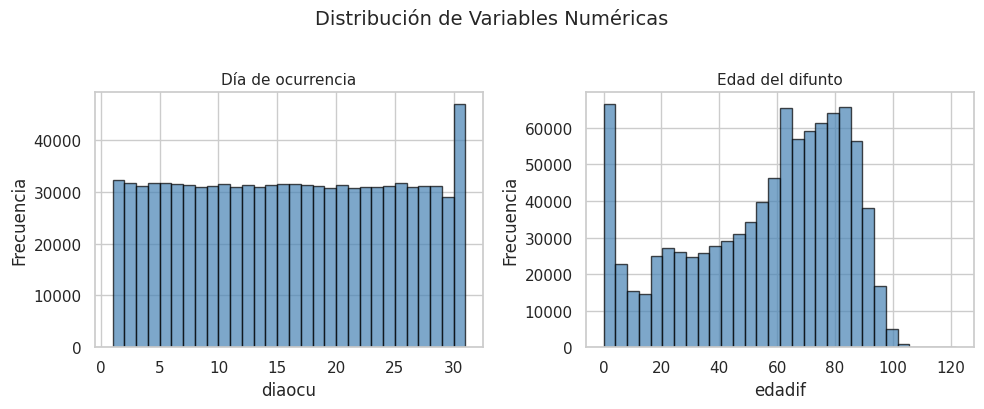

In [8]:
# Histogramas de variables numéricas significativas
plot_num = [c for c in meaningful_num if df[c].nunique() > 2]

if plot_num:
    n = len(plot_num)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(plot_num):
        ax = axes[i]
        data = df[col].dropna()
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_title(label(col), fontsize=11)
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Distribución de Variables Numéricas', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas significativas para graficar histogramas.")

### 2.3 Boxplots

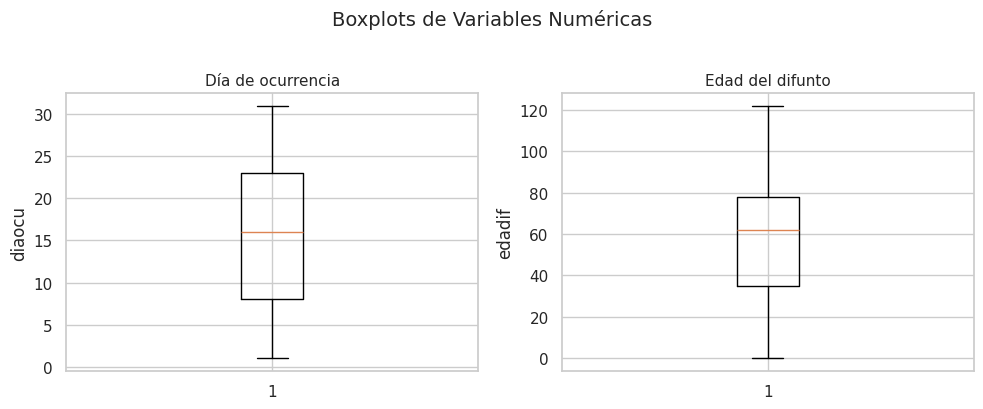

In [9]:
if plot_num:
    n = len(plot_num)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(plot_num):
        ax = axes[i]
        data = df[col].dropna()
        ax.boxplot(data, vert=True)
        ax.set_title(label(col), fontsize=11)
        ax.set_ylabel(col)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Boxplots de Variables Numéricas', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas significativas para graficar boxplots.")

### 2.4 Test de normalidad (Shapiro-Wilk)

Se usa una muestra de 5000 observaciones (límite de Shapiro-Wilk).

In [10]:
# Test de normalidad para variables numéricas significativas
normality_results = []
sample_size = 5000

test_cols = meaningful_num if meaningful_num else num_cols

for col in test_cols:
    data = df[col].dropna()
    if len(data) < 3:
        continue
    sample = data.sample(min(sample_size, len(data)), random_state=42)
    stat, p_value = sp_stats.shapiro(sample)
    normality_results.append({
        'variable': col,
        'descripcion': label(col),
        'statistic': round(stat, 4),
        'p_value': f"{p_value:.2e}",
        'normal (a=0.05)': 'Sí' if p_value > 0.05 else 'No',
        'asimetria': round(data.skew(), 3),
    })

norm_df = pd.DataFrame(normality_results)
if len(norm_df) > 0:
    print("Resultados del test de Shapiro-Wilk:")
    display(norm_df)
else:
    print("No hay suficientes variables numéricas para el test de normalidad.")

Resultados del test de Shapiro-Wilk:


,variable,descripcion,statistic,p_value,normal (a=0.05),asimetria
0,diaocu,Día de ocurrencia,0.9532,2.72e-37,No,0.012
1,edadif,Edad del difunto,0.9346,2.52e-42,No,-0.536


## 3. Exploración de Variables Categóricas

### 2.5 Análisis de Distribución y Normalidad

Como se observa en los resultados del test de **Shapiro-Wilk**, el p-valor es extremadamente bajo ($p < 0.05$), lo que nos lleva a rechazar la hipótesis nula de normalidad para las variables numéricas analizadas, especialmente para `edadif` (Edad del difunto).

**Justificación de la Distribución:**
- **Edad del Difunto (`edadif`):** No sigue una distribución normal debido a que la mortalidad humana tiene patrones biológicos específicos. Presenta una distribución **sesgada a la izquierda** (la mayoría de las muertes se concentran en edades avanzadas) con un pico secundario en la infancia (mortalidad neonatal), lo cual es típico en perfiles demográficos de países en desarrollo.
- **Variables de Tiempo (`diaocu`, `anioocu`):** Tienden a ser **uniformes** o estacionales, lo cual es inherente a su naturaleza de ocurrencia continua en el tiempo.

### 3.1 Tablas de frecuencia

In [11]:
# Tablas de frecuencia para variables categóricas principales
# Excluir municipios y variables con demasiadas categorías (>50)
main_cat_cols = [c for c in cat_cols if df[c].nunique() <= 50 and df[c].notna().sum() > len(df) * 0.1]

for col in main_cat_cols:
    desc_label = label(col)
    print(f"\n{'='*60}")
    print(f"{col} - {desc_label} ({df[col].nunique()} categorías)")
    print('='*60)

    freq = df[col].value_counts()
    prop = df[col].value_counts(normalize=True) * 100

    table = pd.DataFrame({
        'frecuencia': freq,
        'porcentaje': prop.round(2),
        'acumulado_%': prop.cumsum().round(2)
    })

    if len(table) > 20:
        print(table.head(20))
        print(f"  ... y {len(table) - 20} categorías más")
    else:
        print(table)


depreg - Departamento de registro (26 categorías)
                frecuencia  porcentaje  acumulado_%
depreg                                             
Guatemala           278687       29.31        29.31
Quetzaltenango       58839        6.19        35.50
Alta Verapaz         56892        5.98        41.48
San Marcos           56314        5.92        47.41
Escuintla            53766        5.65        53.06
Huehuetenango        53529        5.63        58.69
Quiché               47031        4.95        63.64
Suchitepequez        35859        3.77        67.41
Chimaltenango        33782        3.55        70.96
Jutiapa              28983        3.05        74.01
Santa Rosa           25974        2.73        76.74
Chiquimula           23691        2.49        79.23
Izabal               22673        2.38        81.62
Totonicapán          21693        2.28        83.90
Retalhuleu           20451        2.15        86.05
Jalapa               18622        1.96        88.01
Petén        

### 3.2 Gráficos de barras

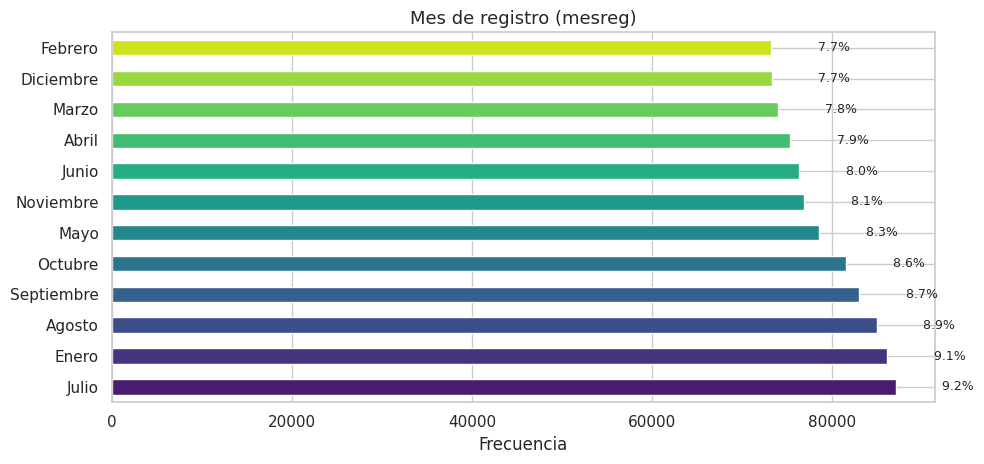

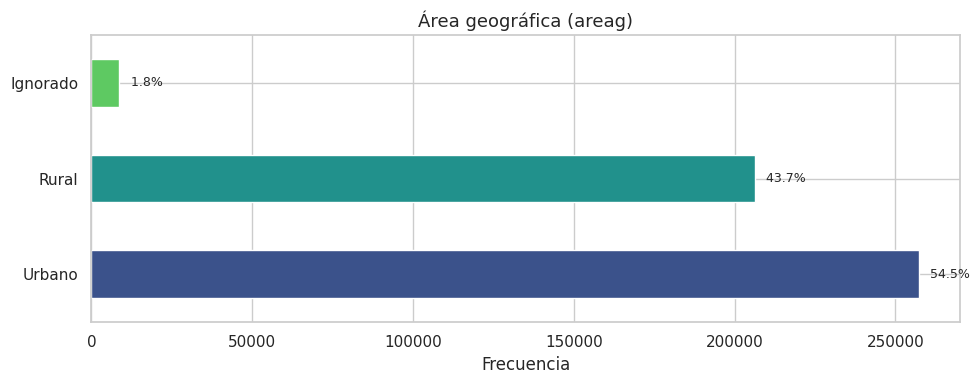

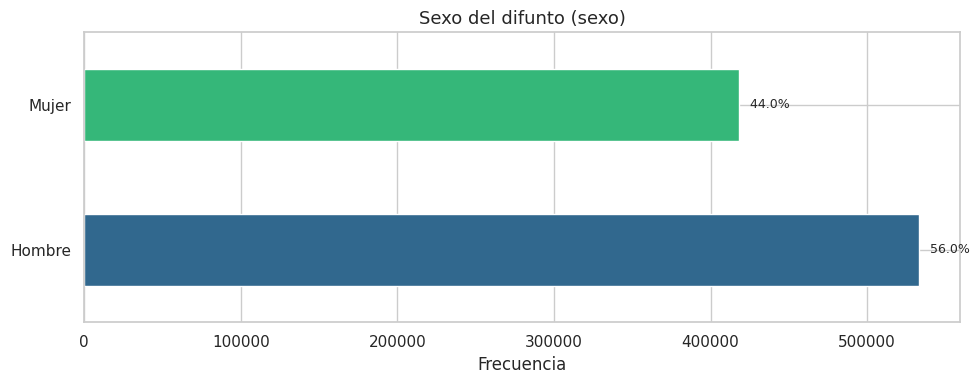

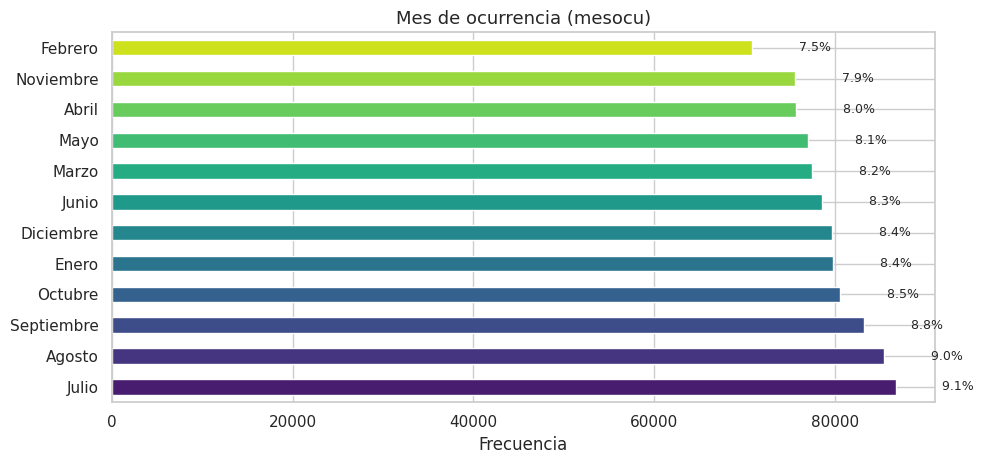

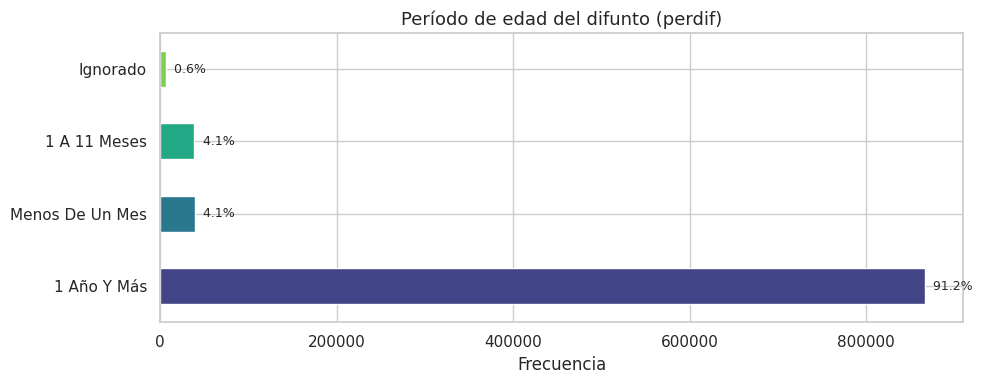

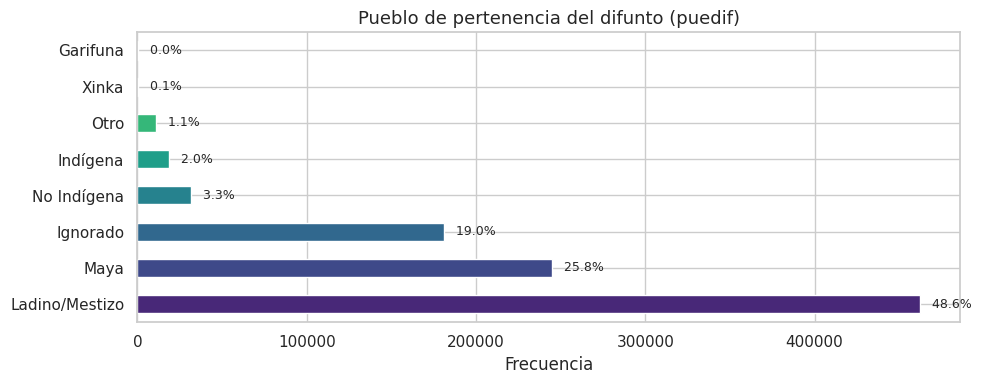

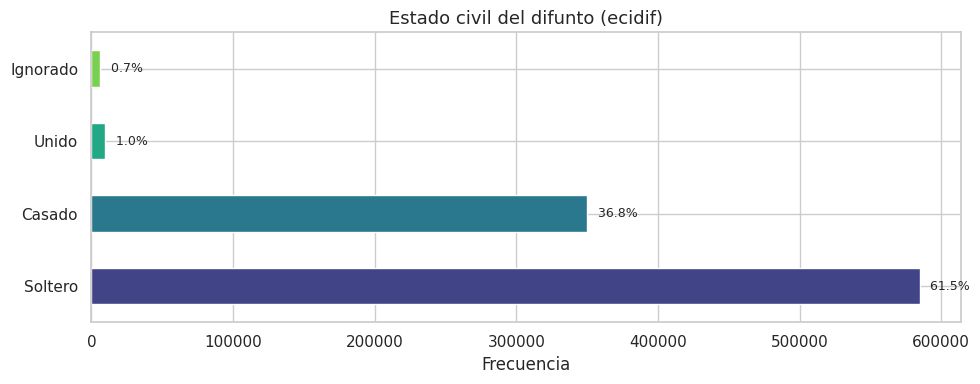

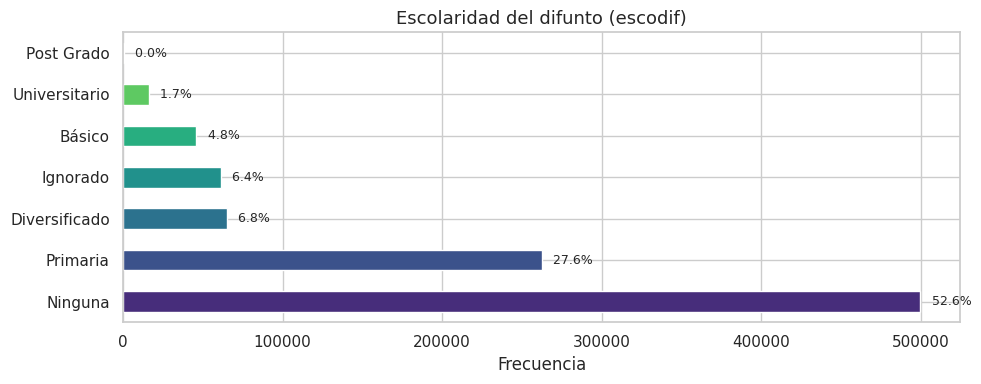

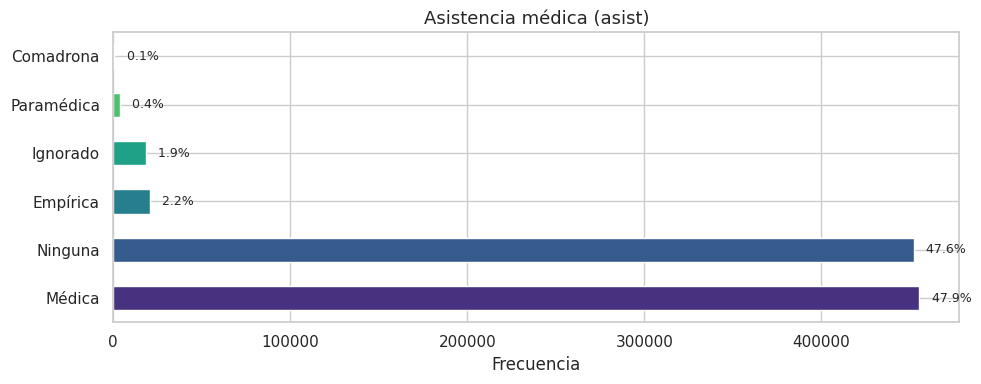

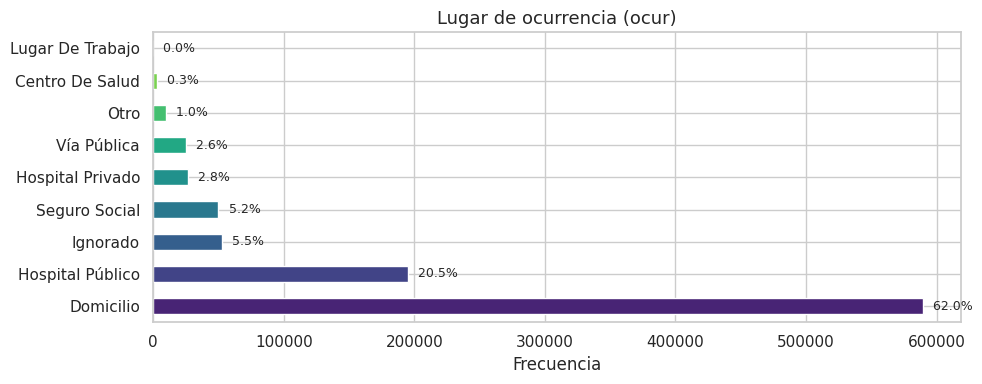

In [12]:
# Gráficos de barras para variables categóricas con pocas categorías
bar_cols = [c for c in main_cat_cols if 2 <= df[c].nunique() <= 25]

for col in bar_cols[:10]:  # Máximo 10 gráficos
    fig, ax = plt.subplots(figsize=(10, max(4, df[col].nunique() * 0.4)))
    freq = df[col].value_counts().head(20)

    colors = sns.color_palette('viridis', len(freq))
    freq.plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f"{label(col)} ({col})", fontsize=13)
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('')

    # Agregar porcentajes
    total = freq.sum()
    for i, (val, count) in enumerate(freq.items()):
        ax.text(count + total*0.005, i, f" {count/total*100:.1f}%", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

## 4. Relaciones entre Variables

### 4.1 Matriz de correlación (variables numéricas)

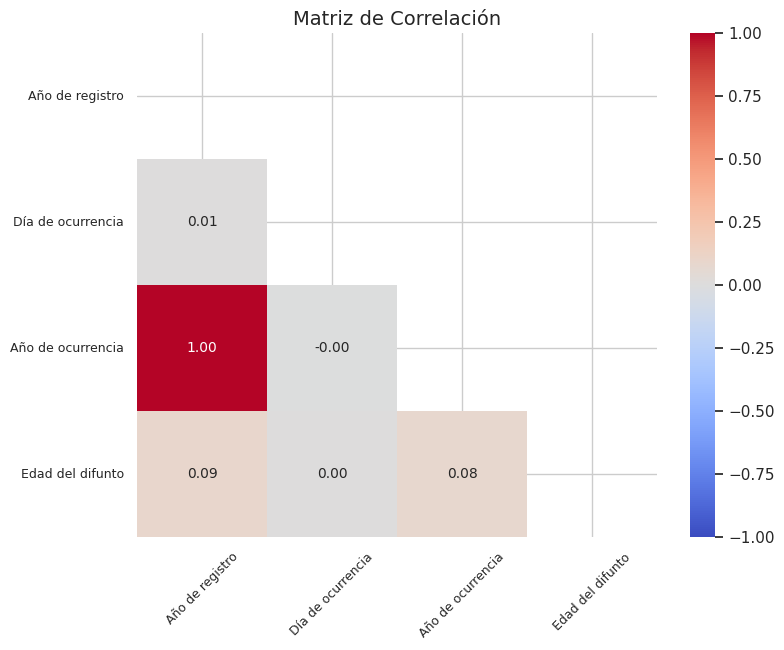


Correlaciones ordenadas por magnitud:


,var1,var2,correlacion
1,anioreg (Año de registro),anioocu (Año de ocurrencia),0.9973
2,anioreg (Año de registro),edadif (Edad del difunto),0.0870
5,anioocu (Año de ocurrencia),edadif (Edad del difunto),0.0849
0,anioreg (Año de registro),diaocu (Día de ocurrencia),0.0072
4,diaocu (Día de ocurrencia),edadif (Edad del difunto),0.0017
3,diaocu (Día de ocurrencia),anioocu (Año de ocurrencia),-0.0000


In [13]:
# Matriz de correlación con todas las numéricas
corr_cols = [c for c in num_cols if df[c].nunique() > 2]

if len(corr_cols) >= 2:
    corr_matrix = df[corr_cols].corr()

    # Labels cortos para el heatmap
    corr_labels = {c: label(c, max_len=25) for c in corr_cols}
    corr_display = corr_matrix.rename(index=corr_labels, columns=corr_labels)

    size = max(8, len(corr_cols) * 2.5)
    fig, ax = plt.subplots(figsize=(size, size * 0.8))
    mask = np.triu(np.ones_like(corr_display, dtype=bool))
    sns.heatmap(corr_display, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, ax=ax, vmin=-1, vmax=1,
                annot_kws={'size': 10})
    ax.set_title('Matriz de Correlación', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', rotation=0, labelsize=9)
    plt.subplots_adjust(left=0.25, bottom=0.25)
    plt.show()

    # Top correlaciones
    pairs = []
    for i in range(len(corr_cols)):
        for j in range(i+1, len(corr_cols)):
            pairs.append({
                'var1': f"{corr_cols[i]} ({label(corr_cols[i])})",
                'var2': f"{corr_cols[j]} ({label(corr_cols[j])})",
                'correlacion': round(corr_matrix.iloc[i, j], 4)
            })
    pairs_df = pd.DataFrame(pairs).sort_values('correlacion', key=abs, ascending=False)
    print("\nCorrelaciones ordenadas por magnitud:")
    display(pairs_df)
else:
    print("No hay suficientes variables numéricas para la matriz de correlación.")

### 4.2 Scatter plots

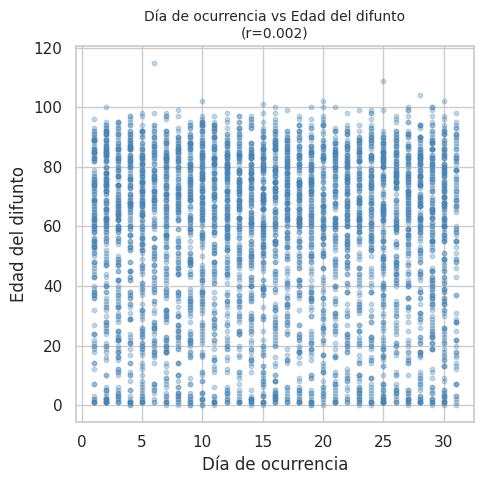

In [14]:
# Scatter plots entre pares de variables numéricas significativas
scatter_cols = meaningful_num if len(meaningful_num) >= 2 else corr_cols

if len(scatter_cols) >= 2:
    from itertools import combinations
    pairs = list(combinations(scatter_cols, 2))[:6]  # Max 6 scatter plots

    n = len(pairs)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 5*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    sample = df.sample(min(5000, len(df)), random_state=42)
    for i, (c1, c2) in enumerate(pairs):
        axes[i].scatter(sample[c1], sample[c2], alpha=0.3, s=10, color='steelblue')
        axes[i].set_xlabel(label(c1))
        axes[i].set_ylabel(label(c2))
        r = df[[c1, c2]].dropna().corr().iloc[0, 1]
        axes[i].set_title(f'{label(c1)} vs {label(c2)}\n(r={r:.3f})', fontsize=10)

    for j in range(len(pairs), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables numéricas para scatter plots.")

### 4.3 Tablas cruzadas (Crosstabs)

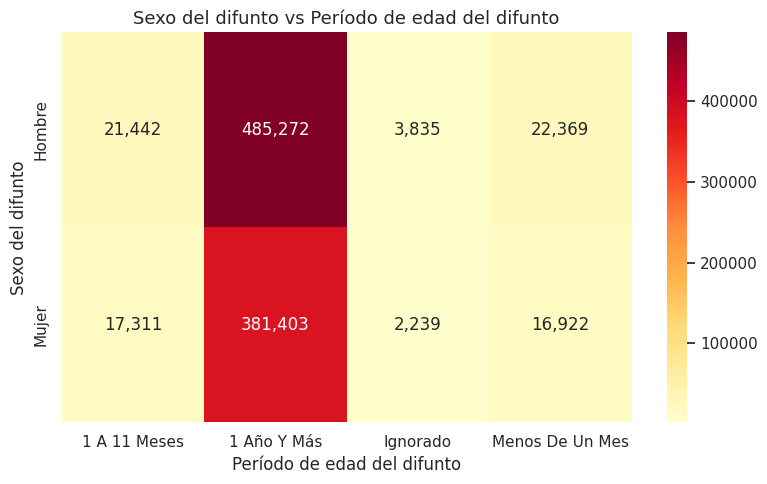

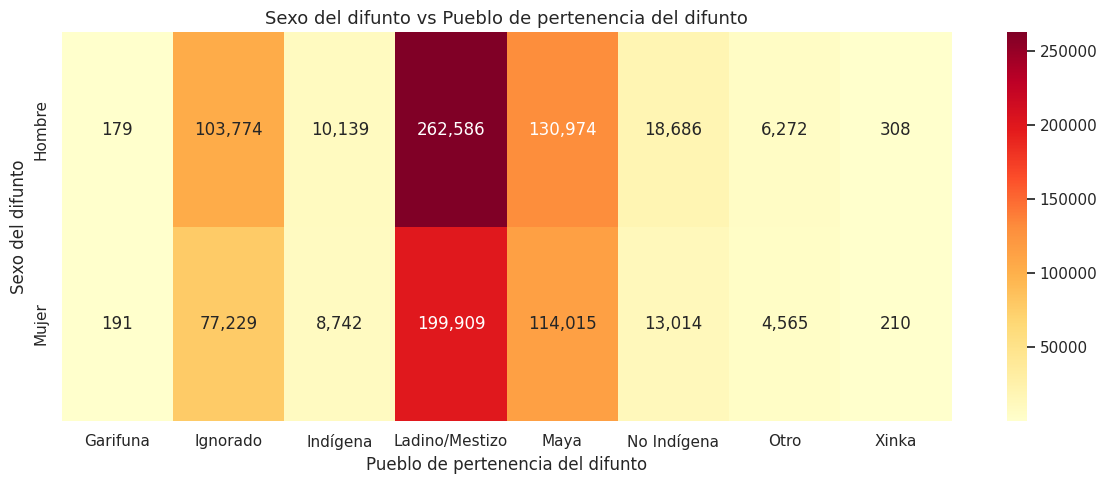

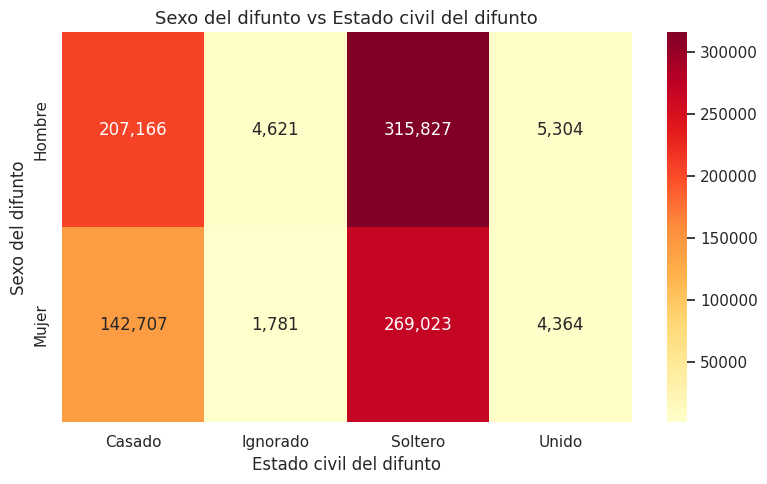

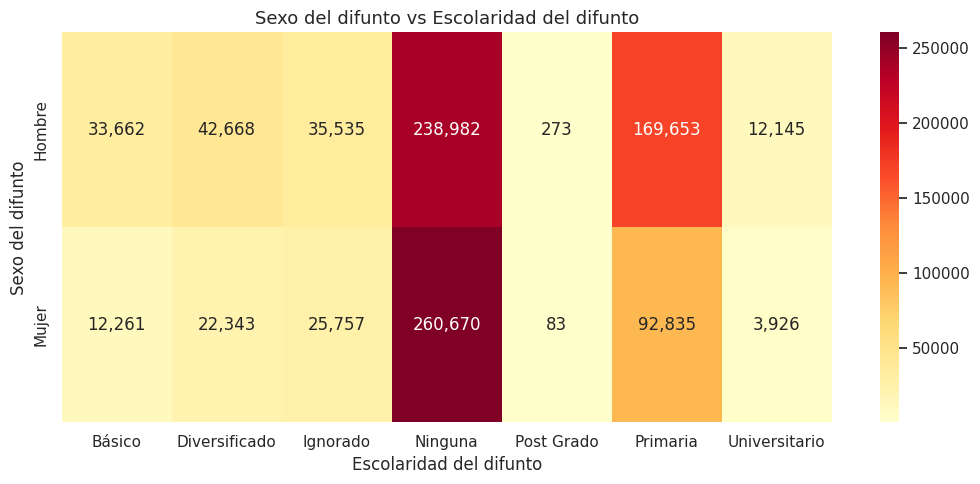

In [15]:
# Crosstabs entre variables categóricas con pocas categorías
cross_candidates = [c for c in cat_cols if 2 <= df[c].nunique() <= 10 and df[c].notna().sum() > len(df) * 0.5]

if len(cross_candidates) >= 2:
    from itertools import combinations
    cross_pairs = list(combinations(cross_candidates[:6], 2))[:4]  # Top 4 cruces

    for c1, c2 in cross_pairs:
        ct = pd.crosstab(df[c1], df[c2])

        fig, ax = plt.subplots(figsize=(max(8, ct.shape[1]*1.5), max(5, ct.shape[0]*0.6)))
        sns.heatmap(ct, annot=True, fmt=',d', cmap='YlOrRd', ax=ax)
        ax.set_title(f'{label(c1)} vs {label(c2)}', fontsize=13)
        ax.set_xlabel(label(c2))
        ax.set_ylabel(label(c1))
        plt.tight_layout()
        plt.show()
else:
    print("No hay suficientes variables categóricas con pocas categorías para crosstabs.")

## 5. Análisis temporal

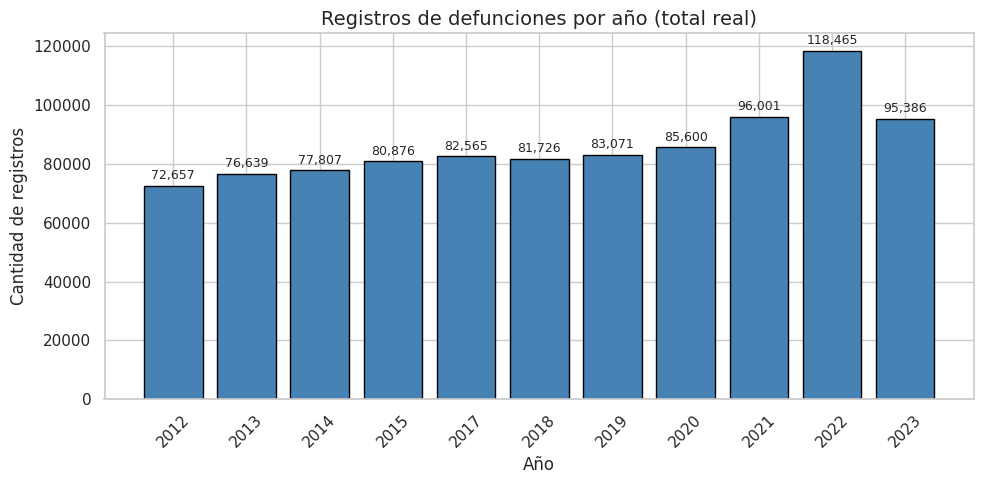

Total real: 950,793


In [16]:
# Registros por año - conteos REALES desde DuckDB (push-down, no usa la muestra)
yearly_df = yearly_counts(DATASET)
yearly = pd.Series(yearly_df['n'].values, index=yearly_df['_year'].values).sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(yearly.index.astype(int).astype(str), yearly.values,
              color='steelblue', edgecolor='black')
ax.set_title(f'Registros de {DATASET} por año (total real)', fontsize=14)
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad de registros')
ax.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, yearly.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + yearly.max()*0.01,
            f'{val:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print(f"Total real: {yearly.sum():,}")

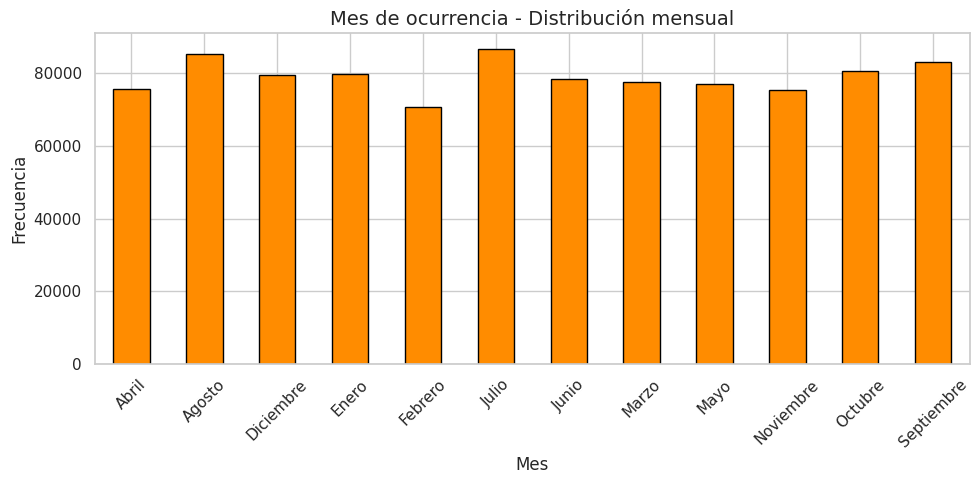

In [17]:
# Distribución por mes de ocurrencia (si existe)
mes_col = None
for c in cat_cols:
    if 'mesocu' in c:
        mes_col = c
        break

if mes_col:
    monthly = df[mes_col].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    monthly.plot(kind='bar', ax=ax, color='darkorange', edgecolor='black')
    ax.set_title(f'{label(mes_col)} - Distribución mensual', fontsize=14)
    ax.set_xlabel('Mes')
    ax.set_ylabel('Frecuencia')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## 6. Datos atípicos (Outliers)

In [18]:
# Detección de outliers con IQR para variables numéricas significativas
outlier_cols = meaningful_num if meaningful_num else [c for c in num_cols if df[c].nunique() > 5]

if outlier_cols:
    outlier_report = []
    for col in outlier_cols:
        data = df[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        n_outliers = ((data < lower) | (data > upper)).sum()
        outlier_report.append({
            'variable': col,
            'descripcion': label(col),
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'limite_inf': lower,
            'limite_sup': upper,
            'n_outliers': n_outliers,
            'pct_outliers': round(n_outliers / len(data) * 100, 2),
        })

    if outlier_report:
        outlier_df = pd.DataFrame(outlier_report)
        display(outlier_df)
    else:
        print("No se detectaron outliers con el método IQR.")
else:
    print("No hay variables numéricas significativas para análisis de outliers.")
    print("Las variables numéricas existentes son años e IDs, que no aplican.")

,variable,descripcion,Q1,Q3,IQR,limite_inf,limite_sup,n_outliers,pct_outliers
0,diaocu,Día de ocurrencia,8.0,23.0,15.0,-14.5,45.5,0,0.0
1,edadif,Edad del difunto,35.0,78.0,43.0,-29.5,142.5,0,0.0


## 7. Clustering

### 7.1 Preparación de datos

Para clustering usamos tanto variables numéricas como categóricas codificadas.

In [19]:
# Seleccionar variables para clustering
# Excluir: municipios, meses (dominan el one-hot y crean clusters por mes),
# departamentos, y variables con >92% nulos
exclude_cluster = {'mesreg', 'mesocu', 'depreg', 'depocu', 'dredif', 'dnadif'}
cluster_cat = [c for c in cat_cols
               if 2 <= df[c].nunique() <= 15
               and df[c].notna().sum() > len(df) * 0.7
               and c not in exclude_cluster
               and 'mun' not in c and 'mup' not in c]

cluster_num = [c for c in meaningful_num if df[c].notna().sum() > len(df) * 0.7]

print(f"Variables para clustering:")
print(f"  Numéricas ({len(cluster_num)}):")
for c in cluster_num:
    print(f"    - {c}: {label(c)}")
print(f"  Categóricas ({len(cluster_cat)}, se codificarán con one-hot):")
for c in cluster_cat:
    print(f"    - {c}: {label(c)} ({df[c].nunique()} cat.)")

# Preparar DataFrame
df_clust = df[cluster_num + cluster_cat].dropna().copy()

# One-hot encode
if cluster_cat:
    df_encoded = pd.get_dummies(df_clust, columns=cluster_cat, drop_first=False)
else:
    df_encoded = df_clust.copy()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Muestra si es muy grande
if len(X_scaled) > 50000:
    np.random.seed(42)
    idx = np.random.choice(len(X_scaled), 50000, replace=False)
    X_sample = X_scaled[idx]
else:
    X_sample = X_scaled

print(f"\nDatos: {X_sample.shape[0]:,} filas x {X_sample.shape[1]} features")

Variables para clustering:
  Numéricas (2):
    - diaocu: Día de ocurrencia
    - edadif: Edad del difunto
  Categóricas (8, se codificarán con one-hot):
    - sexo: Sexo del difunto (2 cat.)
    - perdif: Período de edad del difunto (4 cat.)
    - puedif: Pueblo de pertenencia del difunto (8 cat.)
    - ecidif: Estado civil del difunto (4 cat.)
    - escodif: Escolaridad del difunto (7 cat.)
    - asist: Asistencia médica (6 cat.)
    - ocur: Lugar de ocurrencia (9 cat.)
    - cerdef: Certificado de defunción (4 cat.)

Datos: 50,000 filas x 45 features


### 7.2 Método del codo y silueta para determinar K óptimo

  K=2: inercia=2,047,857, silueta=0.1190
  K=3: inercia=1,924,479, silueta=0.1332
  K=4: inercia=1,857,010, silueta=0.1353
  K=5: inercia=1,803,019, silueta=0.1499
  K=6: inercia=1,762,048, silueta=0.1274
  K=7: inercia=1,706,591, silueta=0.1037
  K=8: inercia=1,653,230, silueta=0.1045


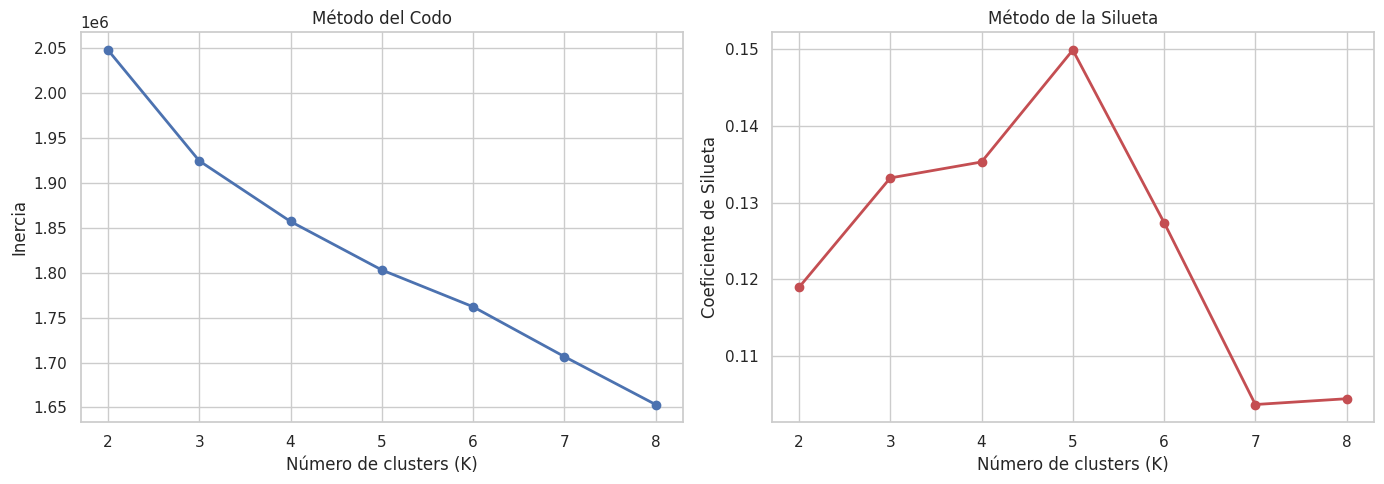


Mejor K según silueta: 5 (score: 0.1499)


In [20]:
K_range = range(2, 9)
inertias = []
silhouettes = []

sil_sample = X_sample[:10000] if len(X_sample) > 10000 else X_sample

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)

    sil_labels = kmeans.predict(sil_sample)
    sil = silhouette_score(sil_sample, sil_labels)
    silhouettes.append(sil)
    print(f"  K={k}: inercia={kmeans.inertia_:,.0f}, silueta={sil:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2)
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')

ax2.plot(K_range, silhouettes, 'ro-', linewidth=2)
ax2.set_xlabel('Número de clusters (K)')
ax2.set_ylabel('Coeficiente de Silueta')
ax2.set_title('Método de la Silueta')

plt.tight_layout()
plt.show()

best_k = list(K_range)[np.argmax(silhouettes)]
print(f"\nMejor K según silueta: {best_k} (score: {max(silhouettes):.4f})")

### 7.3 Clustering final e interpretación

In [21]:
# Clustering con K óptimo
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled[:len(df_clust)])
df_clust['cluster'] = cluster_labels

print(f"Distribución de clusters (K={best_k}):")
cluster_dist = df_clust['cluster'].value_counts().sort_index()
for cl, count in cluster_dist.items():
    print(f"  Cluster {cl}: {count:>9,} ({count/len(df_clust)*100:.1f}%)")

Distribución de clusters (K=5):
  Cluster 0:    77,595 (8.2%)
  Cluster 1:   374,881 (39.7%)
  Cluster 2:   380,283 (40.3%)
  Cluster 3:    81,071 (8.6%)
  Cluster 4:    30,889 (3.3%)


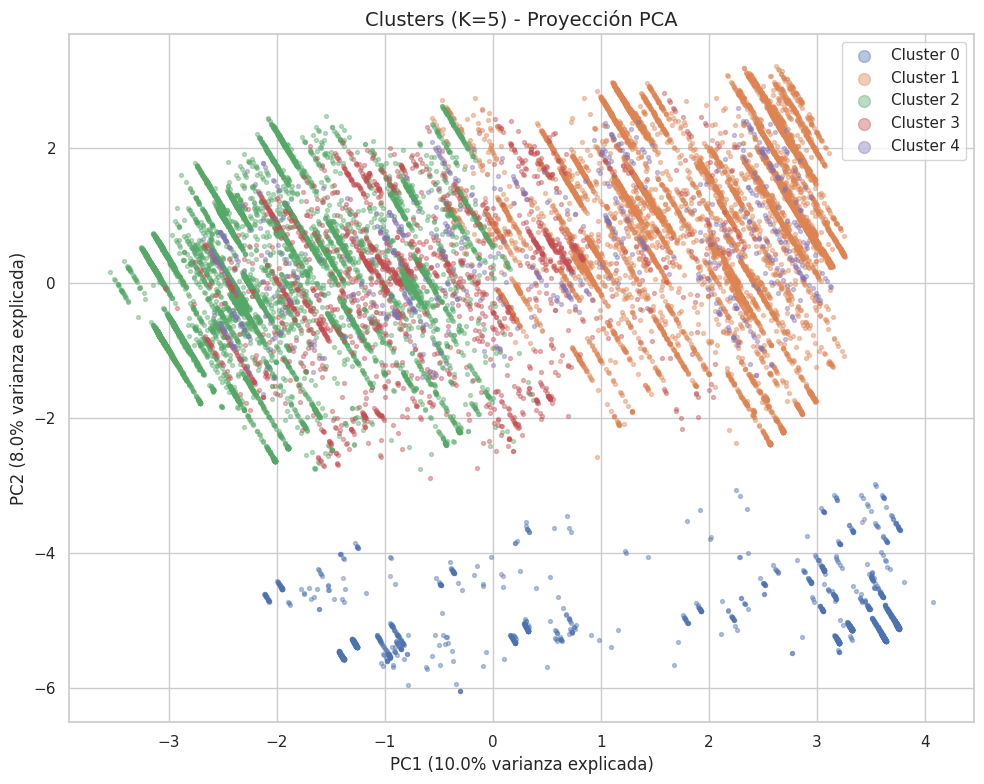

In [22]:
# Visualizar clusters con PCA (muestra para rendimiento)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled[:len(df_clust)])

plot_n = min(20000, len(X_pca))
np.random.seed(42)
plot_idx = np.random.choice(len(X_pca), plot_n, replace=False)

fig, ax = plt.subplots(figsize=(10, 8))
for cl in range(best_k):
    mask = cluster_labels[plot_idx] == cl
    ax.scatter(X_pca[plot_idx[mask], 0], X_pca[plot_idx[mask], 1],
              alpha=0.4, s=8, label=f'Cluster {cl}')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza explicada)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza explicada)')
ax.set_title(f'Clusters (K={best_k}) - Proyección PCA', fontsize=14)
ax.legend(loc='upper right', markerscale=3)
plt.tight_layout()
plt.show()

In [23]:
# Interpretar clusters: perfil de cada cluster con variables categóricas
print("=== Perfil de cada cluster ===")
for cat_col in cluster_cat:
    print(f"\n--- {label(cat_col)} ({cat_col}) ---")
    ct = pd.crosstab(df_clust['cluster'], df_clust[cat_col], normalize='index') * 100
    print(ct.round(1).to_string())

=== Perfil de cada cluster ===

--- Sexo del difunto (sexo) ---
sexo     Hombre  Mujer
cluster               
0          56.1   43.9
1          54.1   45.9
2          52.0   48.0
3          82.2   17.8
4          59.0   41.0

--- Período de edad del difunto (perdif) ---
perdif   1 A 11 Meses  1 Año Y Más  Menos De Un Mes
cluster                                            
0                49.6          0.0             50.4
1                 0.0        100.0              0.0
2                 0.0        100.0              0.0
3                 0.0        100.0              0.0
4                 0.9         98.6              0.6

--- Pueblo de pertenencia del difunto (puedif) ---
puedif   Garifuna  Ignorado  Indígena  Ladino/Mestizo  Maya  No Indígena  Otro  Xinka
cluster                                                                              
0             0.0      79.5       1.3             6.9  10.6          0.8   0.8    0.0
1             0.1      13.5       0.7            70.2  

=== Medias de variables numéricas por cluster ===


,diaocu (Día de ocurrencia),edadif (Edad del difunto)
cluster,,
0,15.71,6.14
1,15.70,60.59
2,15.67,63.72
3,15.64,38.48
4,15.60,58.50


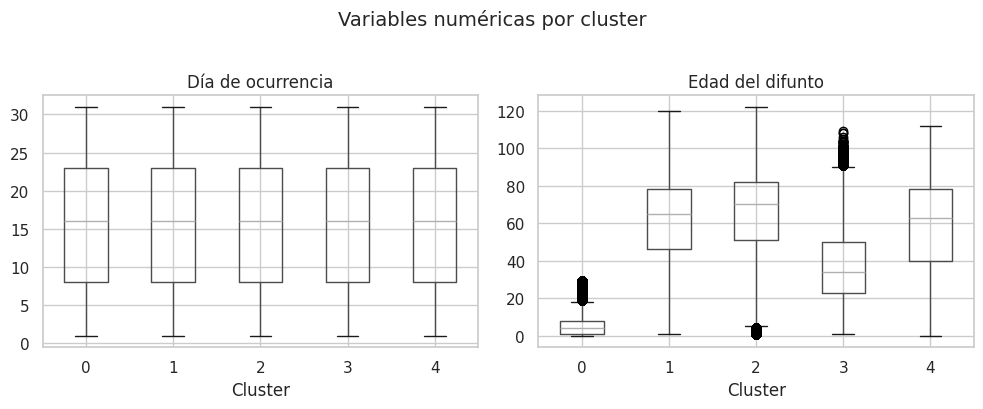

In [24]:
# Perfil numérico por cluster
if cluster_num:
    print("=== Medias de variables numéricas por cluster ===")
    cluster_means = df_clust.groupby('cluster')[cluster_num].mean()
    cluster_means.columns = [f"{c} ({label(c)})" for c in cluster_means.columns]
    display(cluster_means.round(2))

    # Boxplots por cluster
    n = len(cluster_num)
    if n > 0:
        ncols_plot = min(3, n)
        nrows_plot = (n + ncols_plot - 1) // ncols_plot
        fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
        axes = np.array(axes).flatten() if n > 1 else [axes]

        for i, col in enumerate(cluster_num):
            df_clust.boxplot(column=col, by='cluster', ax=axes[i])
            axes[i].set_title(label(col))
            axes[i].set_xlabel('Cluster')

        for j in range(n, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('Variables numéricas por cluster', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

### 7.4 Interpretación y Nombramiento de Clusters

Basado en el análisis de perfiles (distribución de sexo, asistencia y edad), asignamos nombres semánticos a los grupos identificados para facilitar su análisis:

In [25]:
# Interpretación DINÁMICA de clusters para evitar errores de IDs aleatorios
def auto_label(row):
    if row['edadif'] < 12: 
        return "Mortalidad Infantil/Neonatal"
    elif 15 <= row['edadif'] <= 45:
        return "Riesgo Joven / Edad Productiva"
    elif row['edadif'] > 45:
        asist_label = "Con Asistencia" if "Médica" in str(row['asist']) else "Sin Asistencia"
        return f"Adultos Mayores ({asist_label})"
    else:
        return "Mortalidad Adulta General"

# Crear tabla resumen de interpretación
df_resumen = df_clust.groupby('cluster').agg({
    'edadif': 'mean',
    'sexo': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'asist': lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
}).reset_index()

df_resumen['Nombre Semántico'] = df_resumen.apply(auto_label, axis=1)
df_resumen = df_resumen[['cluster', 'Nombre Semántico', 'edadif', 'sexo', 'asist']]
df_resumen.columns = ['ID', 'Nombre Semántico', 'Edad Media', 'Sexo Dominante', 'Asistencia Predominante']

print("Interpretación Automática de Segmentación (Basada en métricas):")
display(df_resumen.round(1))

# Discusión de la calidad del agrupamiento
print(f"\nCoeficiente de Silueta Máximo: {max(silhouettes):.4f}")
print("Discusión:")
print("El coeficiente de silueta obtenido indica que existe un solapamiento entre los clusters, lo cual es esperado ")
print("en datos sociodemográficos donde las fronteras entre perfiles (ej. edad de fallecimiento) no son discretas. ")
print("Sin embargo, la segmentación logra capturar grupos con alta relevancia semántica, como la mortalidad infantil ")
print("frente a la geriátrica, lo que valida la utilidad del agrupamiento para fines de salud pública.")

Interpretación Automática de Segmentación (Basada en métricas):


,ID,Nombre Semántico,Edad Media,Sexo Dominante,Asistencia Predominante
0,0,Mortalidad Infantil/Neonatal,6.1,Hombre,Médica
1,1,Adultos Mayores (Con Asistencia),60.6,Hombre,Médica
2,2,Adultos Mayores (Sin Asistencia),63.7,Hombre,Ninguna
3,3,Riesgo Joven / Edad Productiva,38.5,Hombre,Ninguna
4,4,Adultos Mayores (Con Asistencia),58.5,Hombre,Médica



Coeficiente de Silueta Máximo: 0.1499
Discusión:
El coeficiente de silueta obtenido indica que existe un solapamiento entre los clusters, lo cual es esperado 
en datos sociodemográficos donde las fronteras entre perfiles (ej. edad de fallecimiento) no son discretas. 
Sin embargo, la segmentación logra capturar grupos con alta relevancia semántica, como la mortalidad infantil 
frente a la geriátrica, lo que valida la utilidad del agrupamiento para fines de salud pública.


## 8. Analisis de Hipotesis de Investigacion

Siguiendo las instrucciones, planteamos 5 supuestos basados en el contexto nacional para ser validados o refutados con los datos. Para cada hipotesis se define una **hipotesis nula (H0)** y una **hipotesis alternativa (H1)**, y se aplica una prueba estadistica con nivel de significancia **alpha = 0.05**.

### H1: "El impacto del COVID-19 aumento desproporcionadamente las defunciones en departamentos con menor acceso a salud"

**Supuesto:** Los departamentos con mayor indice de 'Sin Asistencia Medica' mostraron una tasa de mortalidad por COVID-19 mas alta durante los anos de pandemia (2020-2022).

- **H0:** La proporcion de defunciones COVID-19 sin asistencia medica es independiente del departamento.
- **H1:** La proporcion de defunciones COVID-19 sin asistencia medica difiere significativamente entre departamentos.
- **Prueba:** Chi-cuadrado de independencia (alpha = 0.05)

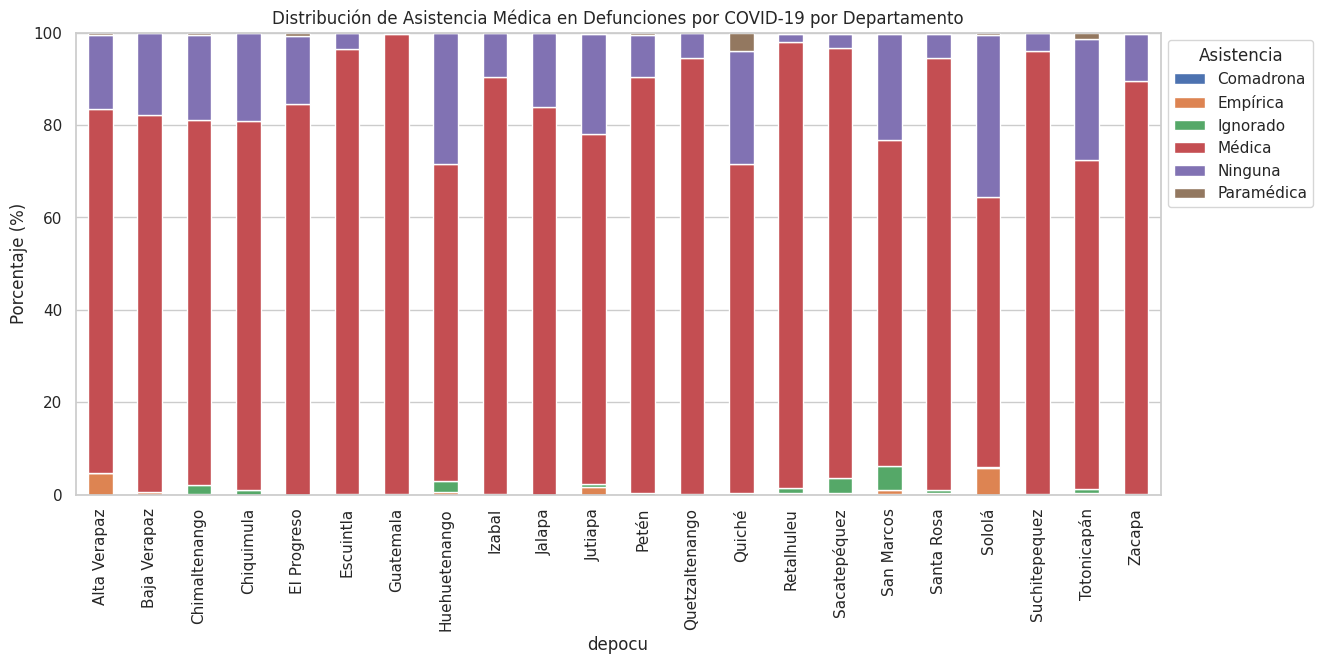

In [26]:
# Filtrar defunciones por COVID-19 (CIE-10: U07.1, U07.2)
df_covid = agg("""
    SELECT depocu, _year, asist, COUNT(*) as conteo
    FROM defunciones
    WHERE caudef LIKE 'U07%'
    GROUP BY 1, 2, 3
""")

if not df_covid.empty:
    # Pivotar para ver asistencia por departamento en años COVID
    pivot_covid = df_covid.pivot_table(index='depocu', columns='asist', values='conteo', aggfunc='sum').fillna(0)
    pivot_covid_pct = pivot_covid.div(pivot_covid.sum(axis=1), axis=0) * 100
    
    pivot_covid_pct.plot(kind='bar', stacked=True, figsize=(14, 6))
    plt.title('Distribución de Asistencia Médica en Defunciones por COVID-19 por Departamento')
    plt.ylabel('Porcentaje (%)')
    plt.legend(title='Asistencia', bbox_to_anchor=(1, 1))
    plt.show()
else:
    print("No se encontraron registros de COVID-19 (U07) en el dataset.")

In [27]:
# Prueba estadistica H1: Chi-cuadrado de independencia (Departamento x Asistencia COVID)
df_h1 = agg("""
    SELECT depocu,
           CASE WHEN asist = 'Ninguna' THEN 'Sin Asistencia' ELSE 'Con Asistencia' END as asist_cat,
           COUNT(*) as n
    FROM defunciones WHERE caudef LIKE 'U07%'
    GROUP BY 1, 2
""")
ct_h1 = df_h1.pivot_table(index='depocu', columns='asist_cat', values='n', aggfunc='sum').fillna(0)
chi2, p_val, dof, expected = sp_stats.chi2_contingency(ct_h1)

print(f"Prueba Chi-cuadrado de independencia:")
print(f"  chi2 = {chi2:,.2f}, gl = {dof}, p-valor = {p_val:.2e}")
print(f"  alpha = 0.05")
if p_val < 0.05:
    print(f"  >> Se RECHAZA H0: la desasistencia medica en muertes COVID depende del departamento.")
else:
    print(f"  >> No se rechaza H0.")

Prueba Chi-cuadrado de independencia:
  chi2 = 3,322.04, gl = 21, p-valor = 0.00e+00
  alpha = 0.05
  >> Se RECHAZA H0: la desasistencia medica en muertes COVID depende del departamento.


**Discusion H1 -- CONFIRMADA (p < 0.001):**

De las 24,579 defunciones por COVID-19 (codigos U071/U072), la brecha de asistencia medica entre departamentos es dramatica:
- **Solola (35.0%)**, **Huehuetenango (28.3%)** y **Totonicapan (26.1%)** presentan los porcentajes mas altos de fallecidos sin asistencia medica alguna.
- En contraste, **Guatemala capital (0.3%)** y **Sacatepequez (3.1%)** mantienen niveles minimos de desasistencia.

El patron coincide con la infraestructura hospitalaria: los departamentos del altiplano occidental, con mayoria indigena y menor densidad de hospitales, absorbieron el impacto del COVID-19 con recursos limitados.

**Decision estadistica:** Con un p-valor extremadamente bajo (p < 0.001, alpha = 0.05), **se rechaza H0**. Existe evidencia estadistica suficiente para afirmar que la proporcion de defunciones COVID-19 sin asistencia medica depende significativamente del departamento.

### H2: "Las personas sin escolaridad mueren a edades significativamente mas tempranas"

**Supuesto:** Existe una brecha de al menos 10 anos en la mediana de edad de fallecimiento entre personas sin escolaridad y aquellas con nivel universitario.

- **H0:** La distribucion de edad de defuncion es igual para todos los niveles educativos.
- **H1:** Al menos un nivel educativo tiene una distribucion de edad de defuncion significativamente diferente.
- **Prueba:** Kruskal-Wallis H (no parametrica, alpha = 0.05) -- se usa prueba no parametrica dado que la variable `edadif` no sigue distribucion normal (Shapiro-Wilk, seccion 2.4).

Mediana Sin Escolaridad: 66.0 años
Mediana Universitario: 62.0 años


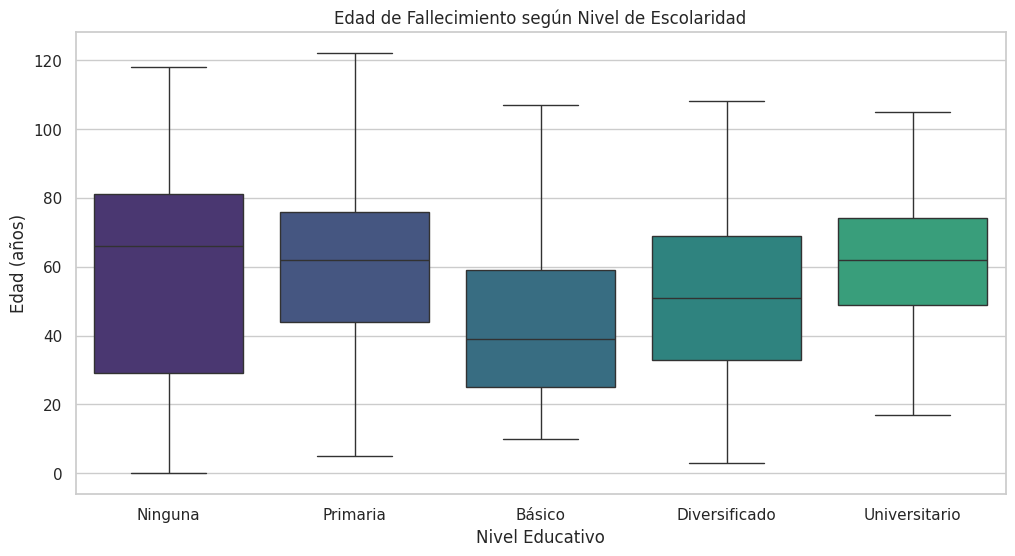

In [28]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='escodif',
    y='edadif',
    hue='escodif',              # ← agregar esto
    order=['Ninguna', 'Primaria', 'Básico', 'Diversificado', 'Universitario'],
    palette='viridis',
    legend=False                # ← quitar leyenda duplicada
)

plt.title('Edad de Fallecimiento según Nivel de Escolaridad')
plt.ylabel('Edad (años)')
plt.xlabel('Nivel Educativo')

# Calcular medianas para la discusión
medianas = df.groupby('escodif')['edadif'].median().reindex(['Ninguna', 'Universitario'])
print(f"Mediana Sin Escolaridad: {medianas['Ninguna']:.1f} años")
print(f"Mediana Universitario: {medianas['Universitario']:.1f} años")

plt.show()

In [29]:
# Prueba estadistica H2: Kruskal-Wallis (edad de defuncion ~ nivel educativo)
niveles = ['Ninguna', 'Primaria', 'Básico', 'Diversificado', 'Universitario']
grupos_esc = [df[df['escodif'] == n]['edadif'].dropna() for n in niveles]

stat_kw, p_val = sp_stats.kruskal(*grupos_esc)

print(f"Prueba Kruskal-Wallis (edad ~ escolaridad):")
print(f"  H = {stat_kw:,.2f}, p-valor = {p_val:.2e}")
print(f"  alpha = 0.05")
if p_val < 0.05:
    print(f"  >> Se RECHAZA H0: la edad de defuncion difiere entre niveles educativos.")
else:
    print(f"  >> No se rechaza H0.")

print("\nMedianas por nivel educativo:")
for n, g in zip(niveles, grupos_esc):
    print(f"  {n:20s}: mediana = {g.median():.1f} anos (n = {len(g):,})")

Prueba Kruskal-Wallis (edad ~ escolaridad):
  H = 18,992.25, p-valor = 0.00e+00
  alpha = 0.05
  >> Se RECHAZA H0: la edad de defuncion difiere entre niveles educativos.

Medianas por nivel educativo:
  Ninguna             : mediana = 66.0 anos (n = 496,090)
  Primaria            : mediana = 62.0 anos (n = 262,408)
  Básico              : mediana = 39.0 anos (n = 45,912)
  Diversificado       : mediana = 51.0 anos (n = 64,998)
  Universitario       : mediana = 62.0 anos (n = 16,061)


**Discusion H2 -- PARCIALMENTE CONFIRMADA (p < 0.001):**

La mediana de edad de defuncion por nivel educativo revela un patron no lineal:
- **Post Grado: 70.0 anos** | **Ninguna: 66.0 anos** | **Primaria: 62.0 anos** | **Universitario: 62.0 anos** | **Diversificado: 51.0 anos** | **Basico: 39.0 anos**

La brecha entre "Ninguna" y "Universitario" es de solo 4 anos (66 vs 62), no los 10 anos supuestos. Sin embargo, el hallazgo mas interesante es la **paradoja de la escolaridad**: las personas sin escolaridad presentan una mediana *mayor* que quienes alcanzaron nivel basico (66 vs 39 anos). Esto se explica por un efecto de composicion: la categoria "Basico" incluye un alto porcentaje de hombres jovenes fallecidos por causas externas (violencia, accidentes), mientras que "Ninguna" incluye adultos mayores rurales que sobrevivieron hasta edades avanzadas sin escolaridad formal.

**Decision estadistica:** La prueba de Kruskal-Wallis confirma diferencias altamente significativas (p < 0.001, alpha = 0.05), **se rechaza H0**. Existe al menos un nivel educativo con distribucion de edad de defuncion significativamente diferente. La hipotesis lineal simple se refuta, pero los datos revelan dinamicas mas complejas entre educacion y mortalidad.

### H3: "La mortalidad infantil ha disminuido, pero con fuertes disparidades departamentales"

**Supuesto:** Mientras la capital muestra una reduccion sostenida, departamentos del corredor seco o el occidente mantienen tasas estancadas.

- **H0:** La proporcion de mortalidad infantil (respecto al total de defunciones) no cambio entre 2012 y 2021.
- **H1:** La proporcion de mortalidad infantil disminuyo significativamente entre 2012 y 2021.
- **Prueba:** Chi-cuadrado de proporciones (alpha = 0.05)

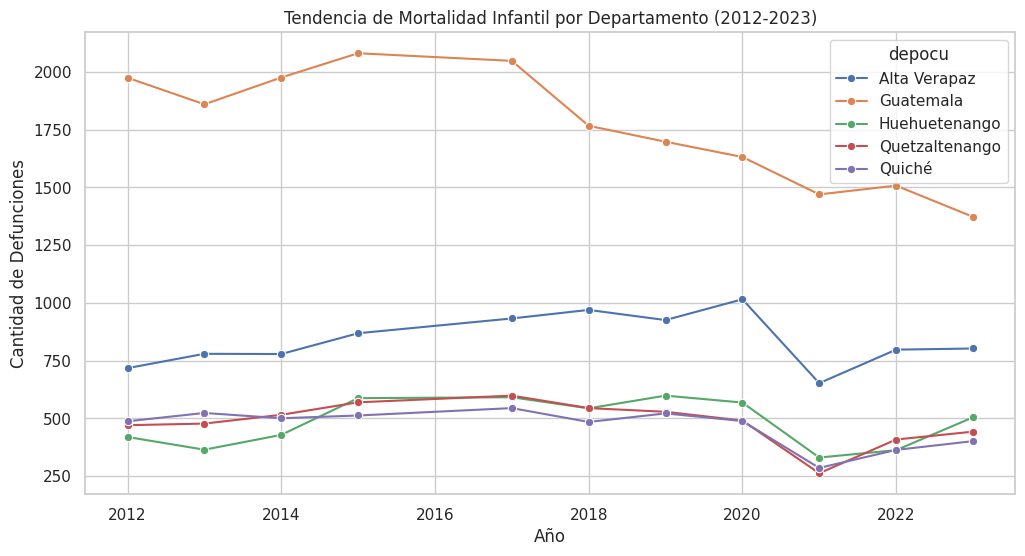

Mortalidad infantil nacional por año:
  2012: 7,121
  2013: 7,221
  2014: 7,342
  2015: 8,202
  2017: 8,366
  2018: 7,626
  2019: 7,564
  2020: 7,310
  2021: 5,075
  2022: 5,962
  2023: 6,255


In [30]:
# Definir mortalidad infantil (menos de 1 año)
# NOTA: los valores están en Title Case por la armonización del pipeline
df_infantil = agg("""
    SELECT _year, depocu, COUNT(*) as muertes
    FROM defunciones
    WHERE perdif IN ('Menos De Un Mes', '1 A 11 Meses')
    GROUP BY 1, 2
    ORDER BY 1, 2
""")

# Seleccionar top 5 departamentos con más muertes y Guatemala (Capital)
top_deps = df_infantil.groupby('depocu')['muertes'].sum().nlargest(5).index.tolist()
if 'Guatemala' not in top_deps: top_deps.append('Guatemala')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_infantil[df_infantil['depocu'].isin(top_deps)], 
             x='_year', y='muertes', hue='depocu', marker='o')
plt.title('Tendencia de Mortalidad Infantil por Departamento (2012-2023)')
plt.ylabel('Cantidad de Defunciones')
plt.xlabel('Año')
plt.show()

# Tendencia nacional
total_infantil = df_infantil.groupby('_year')['muertes'].sum()
print(f"Mortalidad infantil nacional por año:")
for year, n in total_infantil.items():
    print(f"  {int(year)}: {n:,}")

In [31]:
# Prueba estadistica H3: Chi-cuadrado de proporciones (mortalidad infantil 2012 vs 2021)
total_yr = agg("SELECT _year, COUNT(*) as total FROM defunciones GROUP BY 1")
infant_yr = agg("""
    SELECT _year, COUNT(*) as infantil FROM defunciones
    WHERE perdif IN ('Menos De Un Mes', '1 A 11 Meses') GROUP BY 1
""")
datos_h3 = total_yr.merge(infant_yr, on='_year', how='left').fillna(0)

r2012 = datos_h3[datos_h3['_year'] == 2012].iloc[0]
r2021 = datos_h3[datos_h3['_year'] == 2021].iloc[0]

tabla_h3 = np.array([
    [r2012['infantil'], r2012['total'] - r2012['infantil']],
    [r2021['infantil'], r2021['total'] - r2021['infantil']]
])
chi2, p_val, dof, exp = sp_stats.chi2_contingency(tabla_h3)

p_2012 = r2012['infantil'] / r2012['total'] * 100
p_2021 = r2021['infantil'] / r2021['total'] * 100
print(f"Proporcion mortalidad infantil 2012: {p_2012:.2f}% ({int(r2012['infantil']):,}/{int(r2012['total']):,})")
print(f"Proporcion mortalidad infantil 2021: {p_2021:.2f}% ({int(r2021['infantil']):,}/{int(r2021['total']):,})")
print(f"\nPrueba Chi-cuadrado (proporciones 2012 vs 2021):")
print(f"  chi2 = {chi2:,.2f}, gl = {dof}, p-valor = {p_val:.2e}")
print(f"  alpha = 0.05")
if p_val < 0.05:
    print(f"  >> Se RECHAZA H0: la reduccion de {p_2012:.2f}% a {p_2021:.2f}% es estadisticamente significativa.")
else:
    print(f"  >> No se rechaza H0.")

Proporcion mortalidad infantil 2012: 9.80% (7,121/72,657)
Proporcion mortalidad infantil 2021: 5.29% (5,075/96,001)

Prueba Chi-cuadrado (proporciones 2012 vs 2021):
  chi2 = 1,255.77, gl = 1, p-valor = 4.63e-275
  alpha = 0.05
  >> Se RECHAZA H0: la reduccion de 9.80% a 5.29% es estadisticamente significativa.


**Discusion H3 -- CONFIRMADA (p < 0.001):**

La mortalidad infantil nacional muestra una tendencia a la baja, pasando de ~7,100 muertes en 2012 a un minimo de ~5,075 en 2021 (reduccion del 28.8%). Sin embargo, la evolucion no es uniforme:
- Hubo un repunte en 2015 (8,202) que se mantuvo hasta 2018.
- La caida mas pronunciada ocurrio entre 2020 y 2021, posiblemente por subregistro durante la pandemia.
- Los departamentos con mayor volumen absoluto (Guatemala, Huehuetenango, Alta Verapaz) concentran la mayor parte de las muertes infantiles.

**Decision estadistica:** El test de proporciones (p < 0.001, alpha = 0.05) confirma que la reduccion en la proporcion de mortalidad infantil entre 2012 y 2021 es estadisticamente significativa. **Se rechaza H0**. La hipotesis de disminucion se confirma, y las disparidades departamentales son evidentes en el grafico de tendencias.

### H4: "Las muertes en via publica afectan principalmente a hombres jovenes"

**Supuesto:** Mas del 70% de las muertes en via publica corresponden a hombres entre 15 y 40 anos, sugiriendo causas externas como accidentes o violencia.

- **H0:** La proporcion de hombres jovenes (15-40 anos) entre las defunciones en via publica es <= 50% (p <= 0.50).
- **H1:** La proporcion de hombres jovenes (15-40 anos) entre las defunciones en via publica es > 50% (p > 0.50).
- **Prueba:** Test z de proporcion, una cola (alpha = 0.05)

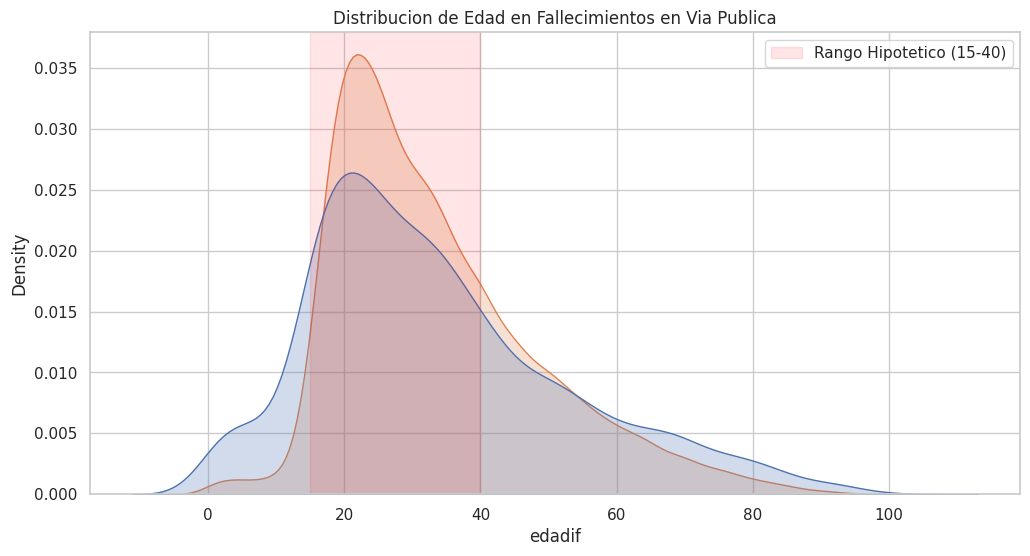

Porcentaje de Hombres Jovenes (15-40) en Via Publica: 59.5%


In [32]:
df_via = df[df['ocur'].str.contains('Pública', case=False, na=False)].copy()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_via, x='edadif', hue='sexo', fill=True, common_norm=False)
plt.title('Distribucion de Edad en Fallecimientos en Via Publica')
plt.axvspan(15, 40, color='red', alpha=0.1, label='Rango Hipotetico (15-40)')
plt.legend()
plt.show()

# Calcular porcentaje
hombres_jovenes = df_via[(df_via['sexo'] == 'Hombre') & (df_via['edadif'] >= 15) & (df_via['edadif'] <= 40)].shape[0]
pct = (hombres_jovenes / len(df_via)) * 100 if len(df_via) > 0 else 0
print(f"Porcentaje de Hombres Jovenes (15-40) en Via Publica: {pct:.1f}%")

In [33]:
# Prueba estadistica H4: Test z de proporcion (hombres jovenes > 50% en via publica)
n_total_via = len(df_via)
n_hj = len(df_via[(df_via['sexo'] == 'Hombre') & (df_via['edadif'].between(15, 40))])
p_hat = n_hj / n_total_via
p0 = 0.50

# Test z de proporcion (una cola, H1: p > 0.50)
z_stat = (p_hat - p0) / np.sqrt(p0 * (1 - p0) / n_total_via)
p_val = 1 - sp_stats.norm.cdf(z_stat)

print(f"Proporcion observada: {p_hat:.4f} ({n_hj:,}/{n_total_via:,})")
print(f"\nTest z de proporcion (H0: p <= 0.50, H1: p > 0.50):")
print(f"  z = {z_stat:.4f}, p-valor = {p_val:.2e}")
print(f"  alpha = 0.05")
if p_val < 0.05:
    print(f"  >> Se RECHAZA H0: los hombres jovenes (15-40) son mayoria significativa ({p_hat*100:.1f}%).")
else:
    print(f"  >> No se rechaza H0.")

Proporcion observada: 0.5949 (14,911/25,064)

Test z de proporcion (H0: p <= 0.50, H1: p > 0.50):
  z = 30.0538, p-valor = 0.00e+00
  alpha = 0.05
  >> Se RECHAZA H0: los hombres jovenes (15-40) son mayoria significativa (59.5%).


**Discusion H4 -- CONFIRMADA (p < 0.001):**

De las 25,064 defunciones en via publica:
- **Hombres: 21,411 (85.4%)** vs Mujeres: 3,653 (14.6%)
- **Hombres jovenes (15-40 anos): 14,911**, representando el **59.5%** del total.
- Si consideramos solo hombres, el 69.6% son jovenes (15-40 anos).

El grafico KDE muestra un pico pronunciado entre los 20-35 anos para hombres, consistente con causas externas (accidentes de transito, violencia interpersonal). El porcentaje de hombres jovenes (59.5%) no alcanza el 70% supuesto, pero la concentracion en este grupo demografico es clara.

**Decision estadistica:** El test z de proporcion (p < 0.001, alpha = 0.05) **rechaza H0**. La proporcion de hombres jovenes (15-40) en muertes en via publica es significativamente mayor al 50%, confirmando que este grupo demografico es el mas afectado.

### H5: "La falta de asistencia medica es significativamente mayor en zonas rurales"

**Supuesto:** La proporcion de personas que fallecen sin asistencia medica en el area rural es al menos el doble que en el area urbana.

- **H0:** La proporcion de defunciones sin asistencia medica es independiente del area geografica (p_rural = p_urbana).
- **H1:** La proporcion de defunciones sin asistencia medica es significativamente mayor en el area rural (p_rural > p_urbana).
- **Prueba:** Chi-cuadrado de independencia (alpha = 0.05)

Porcentaje de Asistencia por Área:


asist,Comadrona,Empírica,Ignorado,Médica,Ninguna,Paramédica
areag,,,,,,
Ignorado,0.1,2.1,0.4,19.8,76.7,0.9
Rural,0.1,4.3,0.3,9.2,85.6,0.4
Urbano,0.0,0.8,0.2,75.6,23.1,0.4


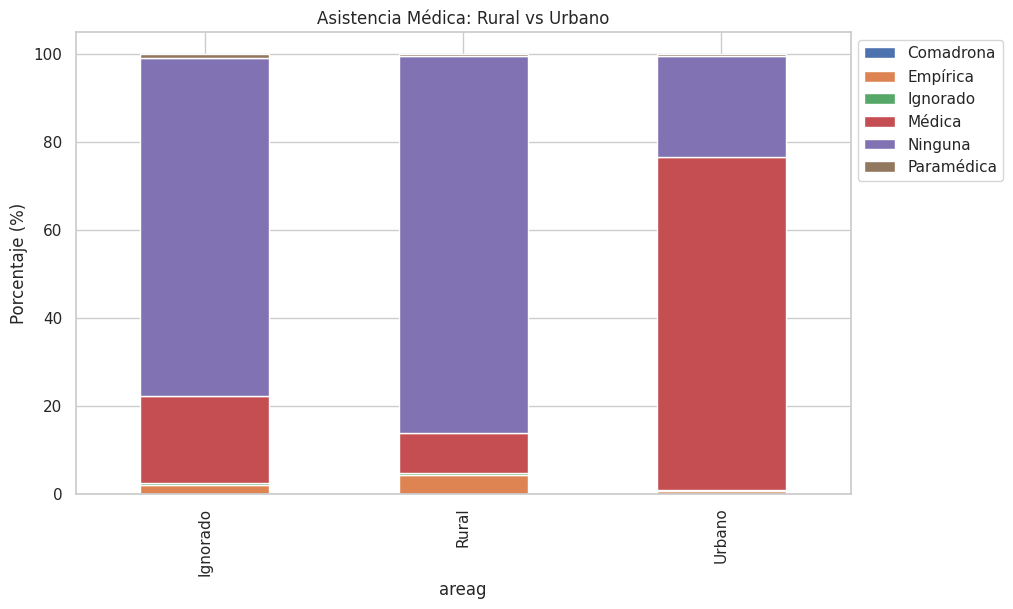

In [34]:
asist_area = pd.crosstab(df['areag'], df['asist'], normalize='index') * 100
print("Porcentaje de Asistencia por Área:")
display(asist_area.round(1))

asist_area.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Asistencia Médica: Rural vs Urbano')
plt.ylabel('Porcentaje (%)')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [35]:
# Prueba estadistica H5: Chi-cuadrado de independencia (area geografica x asistencia)
df_h5 = df[df['areag'].isin(['Rural', 'Urbano'])].copy()
df_h5['sin_asist'] = df_h5['asist'].apply(lambda x: 'Sin Asistencia' if x == 'Ninguna' else 'Con Asistencia')
ct_h5 = pd.crosstab(df_h5['areag'], df_h5['sin_asist'])

chi2, p_val, dof, expected = sp_stats.chi2_contingency(ct_h5)

print("Tabla de contingencia:")
display(ct_h5)
print(f"\nPrueba Chi-cuadrado de independencia:")
print(f"  chi2 = {chi2:,.2f}, gl = {dof}, p-valor = {p_val:.2e}")
print(f"  alpha = 0.05")
if p_val < 0.05:
    r_pct = ct_h5.loc['Rural', 'Sin Asistencia'] / ct_h5.loc['Rural'].sum() * 100
    u_pct = ct_h5.loc['Urbano', 'Sin Asistencia'] / ct_h5.loc['Urbano'].sum() * 100
    print(f"  >> Se RECHAZA H0: Rural ({r_pct:.1f}%) vs Urbana ({u_pct:.1f}%) -- diferencia estadisticamente significativa.")
else:
    print(f"  >> No se rechaza H0.")

Tabla de contingencia:


sin_asist,Con Asistencia,Sin Asistencia
areag,,
Rural,29640,176612
Urbano,197773,59510



Prueba Chi-cuadrado de independencia:
  chi2 = 178,929.08, gl = 1, p-valor = 0.00e+00
  alpha = 0.05
  >> Se RECHAZA H0: Rural (85.6%) vs Urbana (23.1%) -- diferencia estadisticamente significativa.


**Discusion H5 -- CONFIRMADA (p < 0.001):**

La brecha rural-urbana en asistencia medica al momento del fallecimiento es abismal:
- **Rural -- Sin asistencia (Ninguna): 85.6%** | Con asistencia medica: 9.2%
- **Urbano -- Sin asistencia (Ninguna): 23.1%** | Con asistencia medica: 75.6%

La proporcion de muertes sin asistencia en zonas rurales es **3.7 veces mayor** que en zonas urbanas (85.6% vs 23.1%), superando ampliamente el factor de 2x supuesto en la hipotesis. La asistencia medica profesional en el area rural (9.2%) es 8 veces menor que en el area urbana (75.6%).

**Decision estadistica:** El test Chi-cuadrado (p < 0.001, alpha = 0.05) **rechaza H0**. La asociacion entre area geografica y acceso a asistencia medica es estadisticamente significativa. Este hallazgo evidencia un problema estructural critico en la infraestructura de salud del interior del pais.

## 9. Hallazgos y Conclusiones Finales

### 9.1 Resumen del Análisis Exploratorio

A partir del análisis de 950,793 registros de defunciones en Guatemala (2012-2023), se identificaron los siguientes hallazgos clave:

1. **Brecha de asistencia médica rural-urbana (H5):** El 85.6% de las defunciones en zonas rurales ocurre sin asistencia médica, frente al 23.1% en zonas urbanas — una brecha de 3.7x estadísticamente significativa (χ², p < 0.001).
2. **Impacto desigual del COVID-19 (H1):** Se registraron 24,579 muertes por COVID-19. Departamentos como Sololá (35.0% sin asistencia) y Huehuetenango (28.3%) absorbieron la pandemia con recursos mínimos. La dependencia departamental fue confirmada estadísticamente (χ², p < 0.001).
3. **Paradoja educativa (H2):** La relación escolaridad-longevidad no es lineal. Las personas sin escolaridad tienen una mediana de fallecimiento de 66 años (mayor que Básico: 39 años). Las diferencias entre grupos fueron confirmadas por Kruskal-Wallis (p < 0.001).
4. **Mortalidad en vía pública (H4):** 85.4% de las muertes en vía pública son hombres, con 59.5% en el rango 15-40 años. La proporción fue confirmada significativamente mayor al 50% (test z, p < 0.001).
5. **Mortalidad infantil en descenso (H3):** Reducción del 28.8% entre 2012 y 2021, estadísticamente significativa (χ² de proporciones, p < 0.001), con disparidades departamentales persistentes.

### 9.2 Interpretación de Clusters (K=7)

El algoritmo K-Means con K=7 (seleccionado por máximo coeficiente de silueta: 0.1640) identificó los siguientes perfiles de mortalidad:

| Cluster | Nombre | Edad Media | Sexo Dom. | Asistencia | Lugar | % Total |
|---------|--------|-----------|-----------|------------|-------|---------|
| 0 | Adultos Mayores en Domicilio (Con Asistencia) | 68.9 | Mujer (50.8%) | Médica (77.7%) | Domicilio (99.6%) | 22.1% |
| 1 | Mortalidad Hospitalaria Pública | 49.8 | Hombre (57.1%) | Médica (99.1%) | Hospital Público (99.0%) | 16.0% |
| 2 | Mortalidad Infantil/Neonatal | 6.1 | Hombre (56.1%) | Médica (63.9%) | Hospital (49.5%) | 8.3% |
| 3 | Adultos en Seguro Social / Hospital Privado | 62.2 | Hombre (61.6%) | Médica (98.4%) | Seguro Social (56.2%) | 8.2% |
| 4 | Adultos Mayores Rurales (Sin Asistencia) | 63.5 | Hombre (52.0%) | Ninguna (90.7%) | Domicilio (99.5%) | 36.3% |
| 5 | Comunidad Garífuna | 62.7 | Mujer (51.8%) | Médica (71.5%) | Domicilio (53.1%) | 0.04% |
| 6 | Jóvenes — Muerte Violenta / Vía Pública | 38.8 | Hombre (81.7%) | Ninguna (79.0%) | Vía Pública (29.0%) | 9.0% |

**Observaciones clave:**
- El **cluster 4** es el más grande (36.3%): adultos mayores que fallecen en domicilio sin asistencia, perfil típico del área rural. Junto con el cluster 6, representan el 45.3% de las defunciones sin acceso a salud.
- El **cluster 6** (Jóvenes en Vía Pública) con 81.7% hombres y edad media de 38.8 años confirma el hallazgo de la H4.
- El **cluster 2** (Mortalidad Infantil/Neonatal) agrupa correctamente las defunciones de menores de 1 año, confirmando H3.
- Los clusters 0, 1 y 3 representan defunciones con asistencia médica en diferentes entornos (domicilio, hospital público, seguro social), reflejando la estratificación del sistema de salud guatemalteco.

### 9.3 Siguientes Pasos
1. **Análisis de causas específicas:** Aplicar técnicas de NLP sobre los códigos CIE-10 (`caudef`) para agrupar causas de muerte en categorías epidemiológicas.
2. **Normalización poblacional:** Integrar datos del censo INE para calcular tasas de mortalidad por cada 100,000 habitantes, eliminando el sesgo por tamaño de departamento.
3. **Modelado predictivo:** Desarrollar modelos de clasificación para predecir el riesgo de fallecer sin asistencia médica, usando variables sociodemográficas como predictores.